# Analisis Performa Model Dasar (Plain Network) & Implementasi Residual Connection

## Nama Anggota Kelompok:
1. Muhammad Riveldo Hermawan Putra - 122140037
2. Joshia Fernandes Sectio Purba - 122140170
3. Randy Hendriyawan - 122140171

## Hasil Analisis:

Apakah residual connection mengatasi masalah degradasi?
**Ya.** Dengan arsitektur dan jumlah parameter identik (skip tidak menambah parameter), ResNet-34 mencapai akurasi validasi jauh lebih tinggi dan lebih cepat. Ini menunjukkan gradien mengalir lebih stabil via jalur identitas sehingga jaringan lebih dalam tidak mengalami penurunan performa (degradation) seperti pada Plain-34.

Seberapa signifikan peningkatannya?
Sangat signifikan, sekitar +17.65% (≈+43% relatif). Selain puncak akurasi yang lebih tinggi, kecepatan belajar juga lebih baik (contoh: epoch-1 ResNet sudah melampaui best Plain), yang mengindikasikan optimisasi lebih mudah dan generalization yang lebih kuat pada konfigurasi, data, dan durasi training yang sama.


# Extract Dataset

In [1]:
import gdown

file_id = "1hpBttK3L-pIgDSI_w-YgWAX3brwBgqz6"
output = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1hpBttK3L-pIgDSI_w-YgWAX3brwBgqz6
From (redirected): https://drive.google.com/uc?id=1hpBttK3L-pIgDSI_w-YgWAX3brwBgqz6&confirm=t&uuid=f1d91956-1c19-4113-af4c-14444a5b5d92
To: /content/dataset.zip
100%|██████████| 259M/259M [00:01<00:00, 159MB/s]


'dataset.zip'

In [2]:
import zipfile
import os
!pip install torchinfo

if not os.path.exists("/content/dataset"):
    os.makedirs("/content/dataset")

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/dataset")

print("✅ Dataset extracted to /content/dataset")


✅ Dataset extracted to /content/dataset


# Plain34 Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class PlainBlock(nn.Module):
    """
    Plain Block without residual connection.
    This is equivalent to a ResNet BasicBlock but without the skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(PlainBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for dimension matching (if needed)
        self.downsample = downsample

    def forward(self, x):
        # Store input for potential downsampling
        identity = x

        # First conv + bn + relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Second conv + bn
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply downsample to identity if needed (for dimension matching)
        if self.downsample is not None:
            identity = self.downsample(identity)

        # NO RESIDUAL CONNECTION HERE (this is the key difference from ResNet)
        # In ResNet, we would do: out += identity
        # But in Plain network, we just apply ReLU directly

        out = F.relu(out)

        return out

class Plain34(nn.Module):
    """
    Plain-34 Network: ResNet-34 architecture without residual connections.

    Architecture:
    - Initial conv layer (7x7, stride=2)
    - MaxPool (3x3, stride=2)
    - 4 stages of Plain blocks:
      - Stage 1: 3 blocks, 64 channels
      - Stage 2: 4 blocks, 128 channels, stride=2 for first block
      - Stage 3: 6 blocks, 256 channels, stride=2 for first block
      - Stage 4: 3 blocks, 512 channels, stride=2 for first block
    - Global Average Pool
    - Fully Connected layer
    """

    def __init__(self, num_classes=5):
        super(Plain34, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Plain block stages
        self.stage1 = self._make_stage(64, 64, 3, stride=1)    # 3 blocks, 64 channels
        self.stage2 = self._make_stage(64, 128, 4, stride=2)   # 4 blocks, 128 channels
        self.stage3 = self._make_stage(128, 256, 6, stride=2)  # 6 blocks, 256 channels
        self.stage4 = self._make_stage(256, 512, 3, stride=2)  # 3 blocks, 512 channels

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        """
        Create a stage consisting of multiple PlainBlocks.

        Args:
            in_channels: Input channels for the first block
            out_channels: Output channels for all blocks in this stage
            num_blocks: Number of blocks in this stage
            stride: Stride for the first block (usually 1 or 2)
        """
        downsample = None

        # If we need to change dimensions or stride, create downsample layer
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []

        # First block (may have stride=2 and different input/output channels)
        layers.append(PlainBlock(in_channels, out_channels, stride, downsample))

        # Remaining blocks (stride=1, same input/output channels)
        for _ in range(1, num_blocks):
            layers.append(PlainBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv + bn + relu + maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        # Plain block stages
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # Final classification layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def create_plain34(num_classes=5):
    """
    Factory function to create Plain-34 model.

    Args:
        num_classes: Number of output classes (default: 5 for Indonesian food dataset)

    Returns:
        Plain34 model instance
    """
    return Plain34(num_classes=num_classes)

def test_model():
    """
    Test function to verify the model works correctly.
    This function creates a model and prints its architecture summary.
    """
    print("Creating Plain-34 model...")
    model = create_plain34(num_classes=5)

    # Print model summary
    print("\n" + "="*50)
    print("PLAIN-34 MODEL ARCHITECTURE SUMMARY")
    print("="*50)

    # Test with typical input size for image classification (224x224)
    try:
        summary(model, input_size=(1, 3, 224, 224), verbose=1)
    except Exception as e:
        print(f"Error in torchinfo summary: {e}")
        print("Trying manual forward pass...")

        # Manual test
        model.eval()
        with torch.no_grad():
            test_input = torch.randn(1, 3, 224, 224)
            output = model(test_input)
            print(f"Input shape: {test_input.shape}")
            print(f"Output shape: {output.shape}")
            print(f"Expected output shape: (1, 5)")
            print(f"Model works correctly: {output.shape == (1, 5)}")

    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return model

if __name__ == "__main__":
    # Test the model when running this file directly
    model = test_model()

    print("\n" + "="*50)
    print("MODEL READY FOR TRAINING!")
    print("="*50)
    print("Next steps:")
    print("1. Load your Indonesian food dataset")
    print("2. Set up data loaders")
    print("3. Define loss function and optimizer")
    print("4. Train the model")
    print("5. Compare with ResNet-34 (with residual connections)")

Creating Plain-34 model...

PLAIN-34 MODEL ARCHITECTURE SUMMARY
Layer (type:depth-idx)                   Output Shape              Param #
Plain34                                  [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─MaxPool2d: 1-3                         [1, 64, 56, 56]           --
├─Sequential: 1-4                        [1, 64, 56, 56]           --
│    └─PlainBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─PlainBlock: 2-2                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│  

# 1. LOAD INDONESIAN FOOD DATASET

In [4]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import os

class IndonesianFoodDataset(Dataset):
    """Indonesian Food Dataset Loader"""
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Create label mapping
        unique_labels = sorted(self.data['label'].unique())
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.class_names = unique_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx]['label']
        label_idx = self.label_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

def find_dataset_paths():
    """Auto-detect dataset paths"""
    possible_paths = [
        ('IF25-4041-dataset/train.csv', 'IF25-4041-dataset/train'),
        ('dataset/train.csv', 'dataset/train'),
        ('train.csv', 'train')
    ]

    for csv_path, img_dir in possible_paths:
        if os.path.exists(csv_path) and os.path.exists(img_dir):
            print(f"Found dataset: {csv_path}")
            return csv_path, img_dir

    print("No dataset found in standard locations")
    return None, None

def load_dataset():
    """Load Indonesian food dataset"""
    csv_path, img_dir = find_dataset_paths()
    if csv_path is None:
        raise FileNotFoundError("Dataset not found")

    # Create dataset without transforms for now
    dataset = IndonesianFoodDataset(csv_path, img_dir, transform=None)

    print(f"Dataset loaded successfully!")
    print(f"Number of samples: {len(dataset)}")
    print(f"Classes: {dataset.class_names}")

    return dataset, csv_path, img_dir

if __name__ == "__main__":
    dataset, csv_path, img_dir = load_dataset()

Found dataset: dataset/train.csv
Dataset loaded successfully!
Number of samples: 1108
Classes: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']


# 2. Set Up Data Loader

In [5]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import numpy as np

def get_transforms():
    """Get data transforms for training and validation"""
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms

def create_data_loaders(batch_size=16, val_split=0.2, num_workers=2):
    """Create train and validation data loaders"""

    # Find dataset paths
    csv_path, img_dir = find_dataset_paths()
    if csv_path is None:
        raise FileNotFoundError("Dataset not found")

    # Get transforms
    train_transforms, val_transforms = get_transforms()

    # Create datasets
    train_dataset = IndonesianFoodDataset(csv_path, img_dir, transform=train_transforms)
    val_dataset = IndonesianFoodDataset(csv_path, img_dir, transform=val_transforms)

    # Split indices
    total_size = len(train_dataset)
    indices = list(range(total_size))
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(indices)

    val_size = int(total_size * val_split)
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    # Create subset datasets
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)

    # Create data loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Data loaders created successfully!")
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Classes: {train_dataset.class_names}")

    return train_loader, val_loader, train_dataset.class_names

if __name__ == "__main__":
    train_loader, val_loader, class_names = create_data_loaders()

Found dataset: dataset/train.csv
Data loaders created successfully!
Train batches: 56
Validation batches: 14
Classes: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']


# 3. Loss Function & Optimizer

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def get_loss_function():
    """Define loss function for classification"""
    criterion = nn.CrossEntropyLoss()
    print("Loss function: CrossEntropyLoss")
    return criterion

def get_optimizer(model, learning_rate=0.001, weight_decay=0.01):
    """Define optimizer for Plain-34 model"""
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    print(f"Optimizer: AdamW")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")

    return optimizer

def get_scheduler(optimizer, num_epochs):
    """Define learning rate scheduler"""
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_epochs,
        eta_min=1e-7
    )

    print(f"Scheduler: CosineAnnealingLR")
    print(f"T_max: {num_epochs}")

    return scheduler

def setup_training_components(model, num_epochs=50):
    """Setup all training components"""

    print("Setting up training components...")
    print("-" * 40)

    # Loss function
    criterion = get_loss_function()

    # Optimizer
    optimizer = get_optimizer(model)

    # Scheduler
    scheduler = get_scheduler(optimizer, num_epochs)

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    return criterion, optimizer, scheduler, device

if __name__ == "__main__":


    model = create_plain34(num_classes=5)
    criterion, optimizer, scheduler, device = setup_training_components(model)

Setting up training components...
----------------------------------------
Loss function: CrossEntropyLoss
Optimizer: AdamW
Learning rate: 0.001
Weight decay: 0.01
Scheduler: CosineAnnealingLR
T_max: 50
Device: cuda


# 4. Train

In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm
import os

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*train_correct/train_total:.2f}%'
        })

    epoch_loss = train_loss / len(train_loader)
    epoch_acc = 100. * train_correct / train_total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_loss = val_loss / len(val_loader)
    epoch_acc = 100. * val_correct / val_total

    return epoch_loss, epoch_acc

def save_checkpoint(model, optimizer, scheduler, epoch, best_acc, class_names,
                   train_losses, val_losses, train_accs, val_accs, filepath):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_acc,
        'class_names': class_names,
        'label_to_idx': {name: idx for idx, name in enumerate(class_names)},
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }, filepath)

def train_plain34():
    """Main training function"""

    print("TRAINING PLAIN-34 MODEL")
    print("=" * 50)

    # Training configuration
    config = {
        'num_epochs': 10,
        'batch_size': 16,
        'learning_rate': 0.001,
        'weight_decay': 0.01,
        'val_split': 0.2,
        'save_best': True,
        'save_every': 10
    }

    # Create data loaders
    train_loader, val_loader, class_names = create_data_loaders(
        batch_size=config['batch_size'],
        val_split=config['val_split']
    )

    # Create model
    model = create_plain34(num_classes=len(class_names))

    # Setup training components
    criterion, optimizer, scheduler, device = setup_training_components(
        model, config['num_epochs']
    )
    model = model.to(device)

    # Training variables
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print(f"\nStarting training for {config['num_epochs']} epochs...")
    print("-" * 50)

    for epoch in range(config['num_epochs']):
        print(f"\nEpoch [{epoch+1}/{config['num_epochs']}]")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'LR: {scheduler.get_last_lr()[0]:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if config['save_best']:
                save_checkpoint(
                    model, optimizer, scheduler, epoch + 1, best_val_acc, class_names,
                    train_losses, val_losses, train_accs, val_accs,
                    'best_plain34_model.pth'
                )
                print(f'New best model saved! Val Acc: {best_val_acc:.2f}%')

        # Save periodic checkpoint
        if (epoch + 1) % config['save_every'] == 0:
            save_checkpoint(
                model, optimizer, scheduler, epoch + 1, best_val_acc, class_names,
                train_losses, val_losses, train_accs, val_accs,
                f'plain34_epoch_{epoch+1}.pth'
            )
            print(f'Checkpoint saved at epoch {epoch+1}')

    print(f"\nTraining completed!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    return model, best_val_acc, class_names

if __name__ == "__main__":
    model, best_acc, class_names = train_plain34()

TRAINING PLAIN-34 MODEL
Found dataset: dataset/train.csv
Data loaders created successfully!
Train batches: 56
Validation batches: 14
Classes: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Setting up training components...
----------------------------------------
Loss function: CrossEntropyLoss
Optimizer: AdamW
Learning rate: 0.001
Weight decay: 0.01
Scheduler: CosineAnnealingLR
T_max: 10
Device: cuda

Starting training for 10 epochs...
--------------------------------------------------

Epoch [1/10]


Training:  38%|███▊      | 21/56 [00:13<00:22,  1.59it/s, Loss=1.7264, Acc=22.02%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]


Train Loss: 1.6396, Train Acc: 23.00%
Val Loss: 1.6324, Val Acc: 26.70%
LR: 0.000976
New best model saved! Val Acc: 26.70%

Epoch [2/10]


Training:   9%|▉         | 5/56 [00:04<00:37,  1.37it/s, Loss=1.5977, Acc=30.21%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


Train Loss: 1.5720, Train Acc: 28.30%
Val Loss: 2.1379, Val Acc: 28.51%
LR: 0.000905
New best model saved! Val Acc: 28.51%

Epoch [3/10]


Training:  86%|████████▌ | 48/56 [00:23<00:02,  2.78it/s, Loss=1.4343, Acc=29.30%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s]


Train Loss: 1.5453, Train Acc: 29.09%
Val Loss: 1.5518, Val Acc: 40.72%
LR: 0.000794
New best model saved! Val Acc: 40.72%

Epoch [4/10]


Training:  45%|████▍     | 25/56 [00:13<00:15,  2.00it/s, Loss=1.5164, Acc=33.17%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s]


Train Loss: 1.5094, Train Acc: 31.00%
Val Loss: 1.5584, Val Acc: 28.96%
LR: 0.000655

Epoch [5/10]


Training:  12%|█▎        | 7/56 [00:04<00:30,  1.60it/s, Loss=1.6165, Acc=32.81%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


Train Loss: 1.4607, Train Acc: 34.39%
Val Loss: 1.3779, Val Acc: 32.13%
LR: 0.000500

Epoch [6/10]


Training:  21%|██▏       | 12/56 [00:06<00:21,  2.04it/s, Loss=1.6359, Acc=30.77%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]


Train Loss: 1.4583, Train Acc: 33.48%
Val Loss: 1.6562, Val Acc: 28.96%
LR: 0.000346

Epoch [7/10]


Training:  48%|████▊     | 27/56 [00:14<00:11,  2.44it/s, Loss=1.3811, Acc=31.25%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


Train Loss: 1.4550, Train Acc: 32.92%
Val Loss: 1.5197, Val Acc: 40.72%
LR: 0.000206

Epoch [8/10]


Training:  79%|███████▊  | 44/56 [00:21<00:06,  1.96it/s, Loss=1.7270, Acc=34.44%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]


Train Loss: 1.4289, Train Acc: 34.05%
Val Loss: 1.4009, Val Acc: 37.56%
LR: 0.000096

Epoch [9/10]


Training:  36%|███▌      | 20/56 [00:10<00:15,  2.28it/s, Loss=1.4532, Acc=41.56%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.51it/s]


Train Loss: 1.3927, Train Acc: 39.46%
Val Loss: 1.3305, Val Acc: 39.37%
LR: 0.000025

Epoch [10/10]


Training:  30%|███       | 17/56 [00:09<00:24,  1.57it/s, Loss=1.6274, Acc=36.11%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]


Train Loss: 1.3835, Train Acc: 36.98%
Val Loss: 1.3598, Val Acc: 37.10%
LR: 0.000000
Checkpoint saved at epoch 10

Training completed!
Best Validation Accuracy: 40.72%


# ResNet34 Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class ResidualBlock(nn.Module):
    """
    Residual Block WITH skip connection.
    This is the standard ResNet BasicBlock with residual connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for dimension matching (if needed)
        self.downsample = downsample

    def forward(self, x):
        # Store input for residual connection
        identity = x

        # First conv + bn + relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Second conv + bn
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply downsample to identity if needed (for dimension matching)
        if self.downsample is not None:
            identity = self.downsample(identity)

        # RESIDUAL CONNECTION HERE (key difference from Plain network)
        out += identity  # This is the skip connection!
        out = F.relu(out)

        return out

class ResNet34(nn.Module):
    """
    ResNet-34 Network: Plain-34 architecture WITH residual connections.

    Architecture:
    - Initial conv layer (7x7, stride=2)
    - MaxPool (3x3, stride=2)
    - 4 stages of Residual blocks:
      - Stage 1: 3 blocks, 64 channels
      - Stage 2: 4 blocks, 128 channels, stride=2 for first block
      - Stage 3: 6 blocks, 256 channels, stride=2 for first block
      - Stage 4: 3 blocks, 512 channels, stride=2 for first block
    - Global Average Pool
    - Fully Connected layer
    """

    def __init__(self, num_classes=5):
        super(ResNet34, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual block stages (same structure as Plain-34 but with skip connections)
        self.stage1 = self._make_stage(64, 64, 3, stride=1)    # 3 blocks, 64 channels
        self.stage2 = self._make_stage(64, 128, 4, stride=2)   # 4 blocks, 128 channels
        self.stage3 = self._make_stage(128, 256, 6, stride=2)  # 6 blocks, 256 channels
        self.stage4 = self._make_stage(256, 512, 3, stride=2)  # 3 blocks, 512 channels

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        """
        Create a stage consisting of multiple ResidualBlocks.

        Args:
            in_channels: Input channels for the first block
            out_channels: Output channels for all blocks in this stage
            num_blocks: Number of blocks in this stage
            stride: Stride for the first block (usually 1 or 2)
        """
        downsample = None

        # If we need to change dimensions or stride, create downsample layer
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []

        # First block (may have stride=2 and different input/output channels)
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))

        # Remaining blocks (stride=1, same input/output channels)
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv + bn + relu + maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        # Residual block stages
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # Final classification layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def create_resnet34(num_classes=5):
    """
    Factory function to create ResNet-34 model.

    Args:
        num_classes: Number of output classes (default: 5 for Indonesian food dataset)

    Returns:
        ResNet34 model instance
    """
    return ResNet34(num_classes=num_classes)

def test_resnet34():
    """
    Test function to verify the ResNet-34 model works correctly.
    This function creates a model and prints its architecture summary.
    """
    print("Creating ResNet-34 model...")
    model = create_resnet34(num_classes=5)

    # Print model summary
    print("\n" + "="*50)
    print("RESNET-34 MODEL ARCHITECTURE SUMMARY")
    print("="*50)

    # Test with typical input size for image classification (224x224)
    try:
        summary(model, input_size=(1, 3, 224, 224), verbose=1)
    except Exception as e:
        print(f"Error in torchinfo summary: {e}")
        print("Trying manual forward pass...")

        # Manual test
        model.eval()
        with torch.no_grad():
            test_input = torch.randn(1, 3, 224, 224)
            output = model(test_input)
            print(f"Input shape: {test_input.shape}")
            print(f"Output shape: {output.shape}")
            print(f"Expected output shape: (1, 5)")
            print(f"Model works correctly: {output.shape == (1, 5)}")

    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Compare with Plain-34
    plain_model = create_plain34(num_classes=5)
    plain_params = sum(p.numel() for p in plain_model.parameters())

    print(f"\nComparison with Plain-34:")
    print(f"Plain-34 parameters: {plain_params:,}")
    print(f"ResNet-34 parameters: {total_params:,}")
    print(f"Difference: {total_params - plain_params:,}")
    print(f"Parameter ratio: {total_params / plain_params:.3f}")

    return model

def compare_architectures():
    """Compare Plain-34 vs ResNet-34 side by side"""

    print("ARCHITECTURE COMPARISON: PLAIN-34 vs RESNET-34")
    print("=" * 60)

    print("\nKey Differences:")
    print("-" * 30)
    print("Plain-34 Block:")
    print("  conv1 → bn1 → relu → conv2 → bn2 → relu")
    print("  (NO skip connection)")
    print()
    print("ResNet-34 Block:")
    print("  conv1 → bn1 → relu → conv2 → bn2 → (+identity) → relu")
    print("  (WITH skip connection: output = conv_path + identity)")

    # Test gradient flow
    print(f"\nGradient Flow:")
    print("-" * 20)
    print("Plain-34: Gradients must flow through ALL layers")
    print("ResNet-34: Gradients can flow through skip connections")
    print("           This helps with vanishing gradient problem")

    # Create test models
    plain_model = create_plain34(num_classes=5)
    resnet_model = create_resnet34(num_classes=5)

    # Test inference time
    import time
    test_input = torch.randn(16, 3, 224, 224)  # Batch of 16 images

    # Plain-34 timing
    plain_model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(10):
            _ = plain_model(test_input)
    plain_time = (time.time() - start_time) / 10

    # ResNet-34 timing
    resnet_model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(10):
            _ = resnet_model(test_input)
    resnet_time = (time.time() - start_time) / 10

    print(f"\nInference Speed (batch size 16):")
    print("-" * 35)
    print(f"Plain-34: {plain_time:.4f} seconds per batch")
    print(f"ResNet-34: {resnet_time:.4f} seconds per batch")
    print(f"Speed difference: {abs(plain_time - resnet_time):.4f} seconds")

if __name__ == "__main__":
    # Test the model when running this file directly
    model = test_resnet34()

    print("\n" + "="*50)
    print("RESNET-34 MODEL READY FOR TRAINING!")
    print("="*50)

    compare_architectures()

    print("\nNext steps:")
    print("1. Train ResNet-34 with same configuration as Plain-34")
    print("2. Compare training performance")
    print("3. Analyze the effect of skip connections")

Creating ResNet-34 model...

RESNET-34 MODEL ARCHITECTURE SUMMARY
Layer (type:depth-idx)                   Output Shape              Param #
ResNet34                                 [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─MaxPool2d: 1-3                         [1, 64, 56, 56]           --
├─Sequential: 1-4                        [1, 64, 56, 56]           --
│    └─ResidualBlock: 2-1                [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─ResidualBlock: 2-2                [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│

# 5. Train ResNet34

In [9]:
import torch
import torch.nn as nn
from tqdm import tqdm
import os

def train_resnet34():
    """Main training function for ResNet-34"""

    print("TRAINING RESNET-34 MODEL")
    print("=" * 50)

    # Training configuration (same as Plain-34)
    config = {
        'num_epochs': 10,
        'batch_size': 16,
        'learning_rate': 0.001,
        'weight_decay': 0.01,
        'val_split': 0.2,
        'save_best': True,
        'save_every': 10
    }

    # Create data loaders
    train_loader, val_loader, class_names = create_data_loaders(
        batch_size=config['batch_size'],
        val_split=config['val_split']
    )

    # Create model
    model = create_resnet34(num_classes=len(class_names)) # Use create_resnet34

    # Setup training components
    criterion, optimizer, scheduler, device = setup_training_components(
        model, config['num_epochs']
    )
    model = model.to(device)

    # Training variables
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print(f"\nStarting training for {config['num_epochs']} epochs...")
    print("-" * 50)

    for epoch in range(config['num_epochs']):
        print(f"\nEpoch [{epoch+1}/{config['num_epochs']}]")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'LR: {scheduler.get_last_lr()[0]:.6f}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if config['save_best']:
                save_checkpoint(
                    model, optimizer, scheduler, epoch + 1, best_val_acc, class_names,
                    train_losses, val_losses, train_accs, val_accs,
                    'best_resnet34_model.pth' # Save with a different name
                )
                print(f'New best model saved! Val Acc: {best_val_acc:.2f}%')

        # Save periodic checkpoint
        if (epoch + 1) % config['save_every'] == 0:
            save_checkpoint(
                model, optimizer, scheduler, epoch + 1, best_val_acc, class_names,
                train_losses, val_losses, train_accs, val_accs,
                f'resnet34_epoch_{epoch+1}.pth' # Save with a different name
            )
            print(f'Checkpoint saved at epoch {epoch+1}')

    print(f"\nTraining completed!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    return model, best_val_acc, class_names, train_losses, val_losses, train_accs, val_accs

if __name__ == "__main__":
    resnet_model, resnet_best_acc, resnet_class_names, resnet_train_losses, resnet_val_losses, resnet_train_accs, resnet_val_accs = train_resnet34()

    # Store training history for comparison
    resnet_history = {
        'train_losses': resnet_train_losses,
        'val_losses': resnet_val_losses,
        'train_accs': resnet_train_accs,
        'val_accs': resnet_val_accs
    }

TRAINING RESNET-34 MODEL
Found dataset: dataset/train.csv
Data loaders created successfully!
Train batches: 56
Validation batches: 14
Classes: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Setting up training components...
----------------------------------------
Loss function: CrossEntropyLoss
Optimizer: AdamW
Learning rate: 0.001
Weight decay: 0.01
Scheduler: CosineAnnealingLR
T_max: 10
Device: cuda

Starting training for 10 epochs...
--------------------------------------------------

Epoch [1/10]


Training:   4%|▎         | 2/56 [00:00<00:20,  2.64it/s, Loss=2.3799, Acc=25.00%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


Train Loss: 1.6431, Train Acc: 29.76%
Val Loss: 1.2313, Val Acc: 44.34%
LR: 0.000976
New best model saved! Val Acc: 44.34%

Epoch [2/10]


Training:  95%|█████████▍| 53/56 [00:25<00:01,  1.59it/s, Loss=1.6178, Acc=28.82%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]


Train Loss: 1.5655, Train Acc: 28.64%
Val Loss: 1.5007, Val Acc: 31.22%
LR: 0.000905

Epoch [3/10]


Training:  93%|█████████▎| 52/56 [00:25<00:01,  2.70it/s, Loss=1.6657, Acc=32.93%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


Train Loss: 1.4776, Train Acc: 32.81%
Val Loss: 1.4134, Val Acc: 40.72%
LR: 0.000794

Epoch [4/10]


Training:  80%|████████  | 45/56 [00:22<00:05,  2.07it/s, Loss=1.8236, Acc=36.14%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]


Train Loss: 1.4130, Train Acc: 37.77%
Val Loss: 1.2417, Val Acc: 40.72%
LR: 0.000655

Epoch [5/10]


Training:   5%|▌         | 3/56 [00:02<00:33,  1.56it/s, Loss=1.4035, Acc=35.94%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.76it/s]


Train Loss: 1.3992, Train Acc: 40.70%
Val Loss: 1.1783, Val Acc: 48.87%
LR: 0.000500
New best model saved! Val Acc: 48.87%

Epoch [6/10]


Training:  52%|█████▏    | 29/56 [00:15<00:14,  1.84it/s, Loss=1.0477, Acc=39.01%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


Train Loss: 1.3245, Train Acc: 43.40%
Val Loss: 1.2249, Val Acc: 46.61%
LR: 0.000346

Epoch [7/10]


Training:  61%|██████    | 34/56 [00:16<00:10,  2.07it/s, Loss=1.7964, Acc=44.49%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


Train Loss: 1.2818, Train Acc: 44.64%
Val Loss: 1.3400, Val Acc: 42.53%
LR: 0.000206

Epoch [8/10]


Training:  41%|████      | 23/56 [00:10<00:15,  2.16it/s, Loss=1.4177, Acc=43.75%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]


Train Loss: 1.2730, Train Acc: 46.45%
Val Loss: 1.1142, Val Acc: 53.39%
LR: 0.000096
New best model saved! Val Acc: 53.39%

Epoch [9/10]


Training:  43%|████▎     | 24/56 [00:12<00:16,  1.93it/s, Loss=1.2933, Acc=48.25%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:04<00:00,  3.22it/s]


Train Loss: 1.2085, Train Acc: 48.37%
Val Loss: 1.0749, Val Acc: 58.37%
LR: 0.000025
New best model saved! Val Acc: 58.37%

Epoch [10/10]


Training:  82%|████████▏ | 46/56 [00:21<00:05,  1.99it/s, Loss=1.2044, Acc=50.14%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


Train Loss: 1.2066, Train Acc: 49.72%
Val Loss: 1.0824, Val Acc: 57.92%
LR: 0.000000
Checkpoint saved at epoch 10

Training completed!
Best Validation Accuracy: 58.37%


# 6. Compare Plain34 and ResNet34

Comparing Plain34 and ResNet34 training performance
Loaded history from best_plain34_model.pth
Loaded history from best_resnet34_model.pth
Plain34 Best Val Acc:  40.72%
ResNet34 Best Val Acc: 58.37%

Plotting training history...


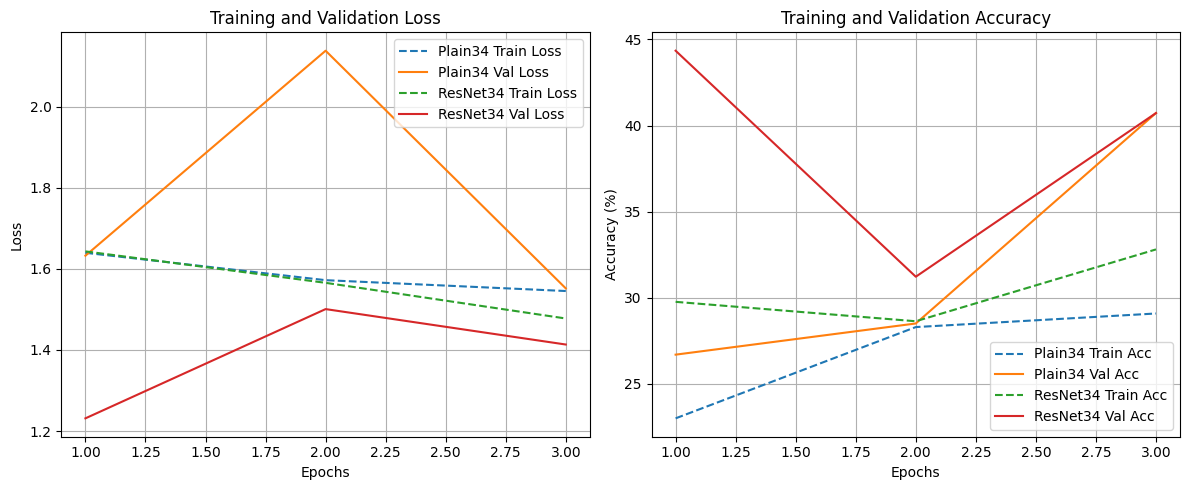


Analysis
----------
ResNet34 performed better. Δ best val acc: 17.65 pp

Check the plots for learning speed, generalization, and overfitting indications.


In [10]:
import os
import torch
import matplotlib.pyplot as plt

# ---- Helpers ----
def _pick(d, *names, default=None):
    """Return first existing key (any alias) from dict d."""
    for n in names:
        if n in d:
            return d[n]
    return default

def _to_list(x):
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    return [x]

def _as_percent(series):
    """If values look like probabilities (<=1), convert to %."""
    if not series:
        return series
    mx = max(abs(v) for v in series if v is not None)
    if mx <= 1.0:  # likely 0..1
        return [None if v is None else (v * 100.0) for v in series]
    return series

# ---- I/O ----
def load_training_history(filepath):
    """Load training history from a saved model checkpoint (robust to formats)."""
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    try:
        ckpt = torch.load(filepath, map_location="cpu")
    except Exception as e:
        print(f"Error loading checkpoint {filepath}: {e}")
        return None

    if not isinstance(ckpt, dict):
        print("Warning: checkpoint is not a dict. Returning empty history.")
        return {'train_losses':[], 'val_losses':[], 'train_accs':[], 'val_accs':[]}, None

    # Some projects store everything under 'history'
    src = ckpt.get("history", ckpt)

    # Accept common aliases
    train_losses = _to_list(_pick(src, "train_losses", "train_loss", "losses_train", default=[]))
    val_losses   = _to_list(_pick(src, "val_losses", "valid_losses", "validation_losses", "losses_val", "val_loss", default=[]))
    train_accs   = _to_list(_pick(src, "train_accs", "train_accuracy", "accs_train", "train_acc", default=[]))
    val_accs     = _to_list(_pick(src, "val_accs", "valid_accs", "validation_accs", "accs_val", "val_acc", "best_acc_curve", default=[]))

    best_val_acc = _pick(ckpt, "best_val_acc", "best_acc", "best_valid_acc", "best_top1", default=None)

    history = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
        "train_accs":   train_accs,
        "val_accs":     val_accs,
    }

    print(f"Loaded history from {filepath}")
    return history, best_val_acc

# ---- Plotting ----
def plot_training_history(plain_history, resnet_history, plain_label="Plain34", resnet_label="ResNet34"):
    """Plot training/validation curves for comparison."""
    # Ensure lists
    for h in (plain_history, resnet_history):
        for k in ("train_losses","val_losses","train_accs","val_accs"):
            h[k] = _to_list(h.get(k, []))

    # Choose comparable epoch count
    min_epochs = min(
        len(plain_history["train_losses"]),
        len(resnet_history["train_losses"]),
        len(plain_history["val_losses"]),
        len(resnet_history["val_losses"]),
    )
    if min_epochs == 0:
        print("Not enough loss data to plot.")
        return

    # Accuracy length may differ; clamp later
    acc_min_epochs = min(
        len(plain_history["train_accs"]),
        len(resnet_history["train_accs"]),
        len(plain_history["val_accs"]),
        len(resnet_history["val_accs"]),
    )

    epochs = range(1, min_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, plain_history["train_losses"][:min_epochs], linestyle="--", label=f"{plain_label} Train Loss")
    plt.plot(epochs, plain_history["val_losses"][:min_epochs],   linestyle="-",  label=f"{plain_label} Val Loss")
    plt.plot(epochs, resnet_history["train_losses"][:min_epochs], linestyle="--", label=f"{resnet_label} Train Loss")
    plt.plot(epochs, resnet_history["val_losses"][:min_epochs],   linestyle="-",  label=f"{resnet_label} Val Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    if acc_min_epochs > 0:
        acc_epochs = range(1, acc_min_epochs + 1)
        p_tr = _as_percent(plain_history["train_accs"][:acc_min_epochs])
        p_va = _as_percent(plain_history["val_accs"][:acc_min_epochs])
        r_tr = _as_percent(resnet_history["train_accs"][:acc_min_epochs])
        r_va = _as_percent(resnet_history["val_accs"][:acc_min_epochs])

        plt.plot(acc_epochs, p_tr, linestyle="--", label=f"{plain_label} Train Acc")
        plt.plot(acc_epochs, p_va, linestyle="-",  label=f"{plain_label} Val Acc")
        plt.plot(acc_epochs, r_tr, linestyle="--", label=f"{resnet_label} Train Acc")
        plt.plot(acc_epochs, r_va, linestyle="-",  label=f"{resnet_label} Val Acc")
        plt.ylabel("Accuracy (%)")
    else:
        plt.text(0.5, 0.5, "No accuracy data", ha="center", va="center", transform=plt.gca().transAxes)
        plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ---- Compare ----
def compare_models(
    plain_checkpoint_path="best_plain34_model.pth",
    resnet_checkpoint_path="best_resnet34_model.pth",
    plain_label="Plain34",
    resnet_label="ResNet34",
):
    print(f"Comparing {plain_label} and {resnet_label} training performance")
    print("=" * 60)

    plain_data = load_training_history(plain_checkpoint_path)
    if plain_data is None:
        print("Cannot compare: failed to load Plain model history.")
        return
    plain_history, plain_best_acc = plain_data

    resnet_data = load_training_history(resnet_checkpoint_path)
    if resnet_data is None:
        print("Cannot compare: failed to load ResNet model history.")
        return
    resnet_history, resnet_best_acc = resnet_data

    def fmt_acc(a):
        if a is None:
            return "N/A"
        return f"{(a*100.0):.2f}%" if a <= 1.0 else f"{a:.2f}%"

    print(f"{plain_label} Best Val Acc:  {fmt_acc(plain_best_acc)}")
    print(f"{resnet_label} Best Val Acc: {fmt_acc(resnet_best_acc)}")

    print("\nPlotting training history...")
    plot_training_history(plain_history, resnet_history, plain_label, resnet_label)

    print("\nAnalysis")
    print("-" * 10)
    if plain_best_acc is not None and resnet_best_acc is not None:
        p = plain_best_acc * 100.0 if plain_best_acc <= 1.0 else plain_best_acc
        r = resnet_best_acc * 100.0 if resnet_best_acc <= 1.0 else resnet_best_acc
        if r > p:
            print(f"{resnet_label} performed better. Δ best val acc: {r - p:.2f} pp")
        elif r < p:
            print(f"{plain_label} performed better. Δ best val acc: {p - r:.2f} pp")
        else:
            print("Both achieved the same best validation accuracy.")
    else:
        print("Best accuracies unavailable for a fair comparison.")

    print("\nCheck the plots for learning speed, generalization, and overfitting indications.")

if __name__ == "__main__":
    compare_models()
